# Recipe Recommender System Model

This notebook presents the python code used to build a recipe recommender system based on BPR.

In [6]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pylab as pl
%matplotlib inline

In [5]:
recipes = [f.path.split("/")[1] for f in os.scandir("recipe_data/") if f.is_dir() ]    
print(recipes[:10])
print("Nb of recipes: " + str(len(recipes)))

['229804', '245348', '25093', '14930', '257743', '255991', '236394', '13148', '18454', '215435']
Nb of recipes: 44069


In [13]:
def getAllUsersWithReviews(start_path, files):
    users = set()
    for file in files:
        try:
            with open(start_path + file + "/reviews.json") as data_file:    
                reviews = json.load(data_file)
                for review in reviews:
                    users.add(review["submitter"]["userID"])
        except: 
            print("Problem with file: " + file)
    return users

In [14]:
users = getAllUsersWithReviews("recipe_data/", recipes)

In [15]:
len(users)

1017178

In [16]:
userRecipes = {}
recipeUsers = {}

for user in users:
    userRecipes[user] = []

for recipe in recipes:
    recipeUsers[recipe] = []

for recipe in recipes:
    with open("recipe_data/" + recipe + "/reviews.json") as data_file:
        reviews = json.load(data_file)
        for review in reviews:
            user = review["submitter"]["userID"]
            userRecipes[user].append(recipe)
            recipeUsers[recipe].append(user)

In [18]:
with open("data/userRecipes.json", "w") as file:
    file.write(json.dumps(userRecipes))

with open("data/recipeUsers.json", "w") as file:
    file.write(json.dumps(recipeUsers))

In [4]:
with open("data/userRecipes.json", "r") as file:
    userRecipes = json.loads(file.read())

with open("data/recipeUsers.json", "r") as file:
    recipeUsers = json.loads(file.read())

In [12]:
users = list(userRecipes.keys())
recipes = list(recipeUsers.keys())

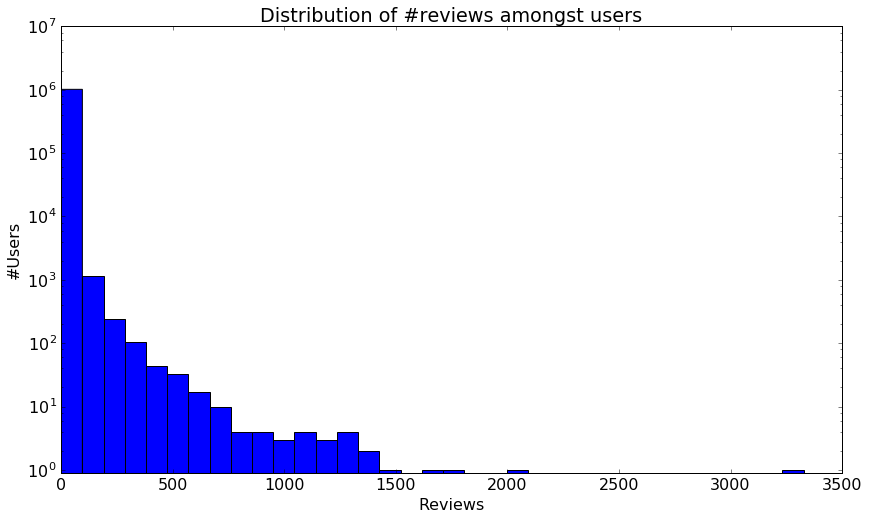

In [13]:
userDistrib = list(map(lambda x: len(userRecipes[x]), users))
fig = pl.gcf()
fig.set_size_inches(14, 8)
plt.hist(userDistrib, bins=35,log=True)
pl.title('Distribution of #reviews amongst users')
pl.xlabel('Reviews')
pl.ylabel('#Users')
font = {'family' : 'sans-serif',
        'size'   : 16}

axes = plt.gca()
axes.set_ylim([0.9,10**7])
matplotlib.rc('font', **font)
plt.show()

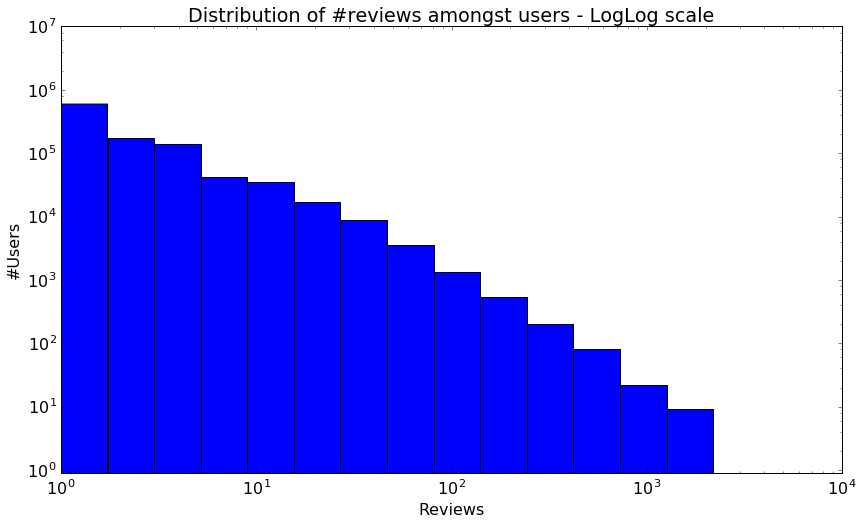

In [14]:
plt.hist(userDistrib, log=True, bins=np.sqrt(3)**(np.arange(0,15)))
fig = pl.gcf()
fig.set_size_inches(14, 8)
plt.xscale('log')

pl.title('Distribution of #reviews amongst users - LogLog scale')
pl.xlabel('Reviews')
pl.ylabel('#Users')

axes = plt.gca()
axes.set_ylim([0.9,10**7])
matplotlib.rc('font', **font)
plt.show()

In [15]:
pdUserDistrib = pd.DataFrame(userDistrib)
pdUserDistrib.columns = ["nb reviews"]
pdUserDistrib.describe()

,nb reviews
count,1.017178e+06
mean,3.306215e+00
std,1.245852e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,3.327000e+03


In [16]:
for i in [3, 5, 10, 20, 50, 100]:
    print(str(len(pdUserDistrib[pdUserDistrib["nb reviews"] >= i])) + " users with at least than " + str(i) + " reviews")

249586 users with at least than 3 reviews
135320 users with at least than 5 reviews
58247 users with at least than 10 reviews
22805 users with at least than 20 reviews
5104 users with at least than 50 reviews
1523 users with at least than 100 reviews


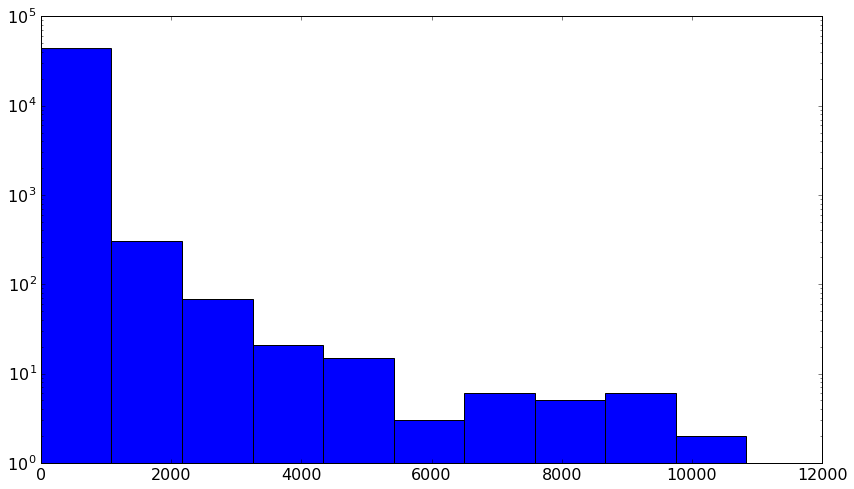

In [17]:
recipeDistrib = list(map(lambda x: len(recipeUsers[x]), recipes))
fig = pl.gcf()
fig.set_size_inches(14, 8)
plt.hist(recipeDistrib,  log=True)
plt.show()

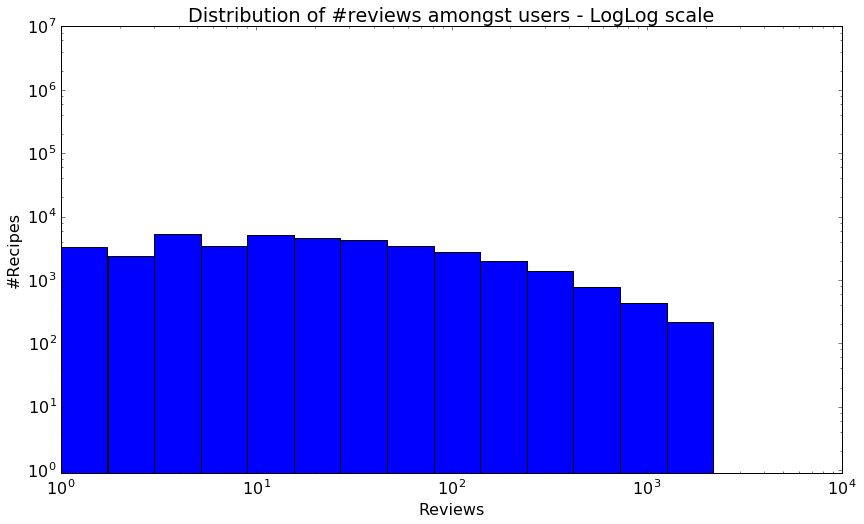

In [18]:
plt.hist(recipeDistrib, log=True, bins=np.sqrt(3)**(np.arange(0,15)))
fig = pl.gcf()
fig.set_size_inches(14, 8)
plt.xscale('log')

pl.title('Distribution of #reviews amongst users - LogLog scale')
pl.xlabel('Reviews')
pl.ylabel('#Recipes')

axes = plt.gca()
axes.set_ylim([0.9,10**7])
matplotlib.rc('font', **font)
plt.show()

In [19]:
pdrecipeDistrib = pd.DataFrame(recipeDistrib)
pdrecipeDistrib.columns = ["nb reviews"]
pdrecipeDistrib.describe()

,nb reviews
count,44069.000000
mean,76.312351
std,293.079980
min,0.000000
25%,3.000000
50%,12.000000
75%,47.000000
max,10835.000000


## Building Model

In [33]:
# Sample 1000 users and 10000 recipes for test
N = 1000
M = 10000

sampleRecipes = np.random.choice(list(recipes), N)
sampleUsers = []
while len(sampleUsers) < M:
    r = np.random.choice(sampleRecipes)
    if(len(recipeUsers[r]) > 1):
        u = np.random.choice(recipeUsers[r])
        if str(u) not in sampleUsers:
            sampleUsers.append(str(u))

In [34]:
W = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        if sampleRecipes[i] in userRecipes[sampleUsers[j]]:
            W[i,j] = 1

In [35]:
sampleInteractions = []

for user in sampleUsers:
    for recipe in sampleRecipes:
        if recipe in userRecipes[user]:
            sampleInteractions.append((recipe, user))

In [36]:
'''interactions = []
for user in users:
    for recipe in userRecipes[user]:
        interactions.append((user, recipe))'''
interactions = np.array(sampleInteractions)

In [37]:
_iter = 2e5; # number of iterations
alpha = 0.05; # learning rate
_lambda = 0.01; # regularizer
sigma = 0.1; # std for random initialization
mu = 0.0; # mean for random initialization
K = 10; # number of latent factors 

# Split test-train
np.random.shuffle(interactions)
test_len = int(len(interactions) / 10)
interactions_te = interactions[:test_len]
interactions_tr = interactions[test_len:]

# Initialize low-rank matrices with random values
P = ((np.random.rand(N,K) * 4) - 2) * sigma # Users
Q = ((np.random.rand(K,M) * 4) - 2) * sigma # Recipes

In [41]:
userRecipe_tr = {}
for interaction in interactions_tr:
    r = interaction[0]
    u = interaction[1]
    if u not in userRecipe_tr:
        userRecipe_tr[u] = [r]
    else:
        userRecipe_tr[u].append(r)

## Use sample instead of real values


In [43]:
recipes = sampleRecipes
users = sampleUsers
interactions = sampleInteractions

## Model

In [42]:
def sample_neg(recipes, user, userRecipes):
    recipe = np.rand.choice(recipes)
    while recipe in userRecipes[user]:
        recipe = np.rand.choice(recipes)
    return recipe

In [50]:
for step in range(_iter):
    
    # Select a random positive example
    i  = np.rand.choice(interactions_tr)
    recipe = i[0]
    user = i[1]
    ir = recipes.index(recipe)
    iu = users.index(user)
    
    # Sample a negative example
    ji = sample_neg(recipes, user, userRecipes);
    
    # See BPR paper for details
    px = (P[iu,:] * (Q[:,ir]-Q[:,ji]));
    z = 1 /(1 + exp(px));
    
    # update P
    d = (Q[:,ir]-Q[:,ji])*z - _lambda*P[iu,:].T
    P[iu,:] = P[iu,:] + alpha*d.T
    
    # update Q positive
    d = P[iu,:]*z - _lambda*Q[:,ir].T
    Q[:,ir] = Q[:,ir] + alpha*d.T
    
    # update Q negative
    d = -P[iu,:]*z - _lambda*Q[:,ji].T
    Q[:,ji] = Q[:,ji] + alpha*d.T
    
    if step % 10000 == 0:
        
        # Compute the Area Under the Curve (AUC)
        auc = 0;
        for i in interactions_te:
            te_i  = randi([1 length(R_idx_te)]);
            te_iu = R_idx_te(i,1);
            te_ir = R_idx_te(i,2);
            te_ji = sample_neg(Rall,te_iu);
            
            sp = P(te_iu,:)*Q(:,te_ir);
            sn = P(te_iu,:)*Q(:,te_ji);
            
            if sp>sn; auc=auc+1; elseif sp==sn; auc=auc+0.5; end
        end
        auc = auc / length(R_idx_te);
        fprintf(['AUC test: ',num2str(auc),'\n']);
    end
    
end


SyntaxError: invalid syntax (<ipython-input-50-257cc4f11ae6>, line 34)